In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import shap
import ast
import toolz
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from scipy.stats import pearsonr,spearmanr
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.feature_selection import *
from sklearn.preprocessing import *
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from sklearn.compose import TransformedTargetRegressor
from utils import RHCF

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
path_inputs="dataset_features_finali/"
#results="results.xlsx"
model="XGB_13_3"
results="results_dataset_luglio.xlsx"
filter_proteins=False

In [4]:
features_todrop=["N1-N3_Hbond",
                 'O_Hbond',
                 'Pi-Pi_Stacking',
                 'Stacking_Alifatico',
                 'Pi_Cation']

In [5]:
df_data=pd.read_excel("data/dataset_input_clean.xlsx",index_col=0)
#proteins=list(df_data[df_data["reference"]!="mancante"].index)

In [6]:
bar_radius=model.split("_")[1]
ring_radius=model.split("_")[2]

In [7]:
data=pd.read_excel("outputs/"+results).drop("Unnamed: 0",axis=1).set_index("name_model_radius")
best_params=ast.literal_eval(data.loc[model]["Best_params"])
best_params=toolz.keymap(lambda x: x.split("__")[2], best_params)
best_params

{'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 100}

In [8]:
data

,estimator,bar_radius,ring_radius,MAE_train,sd_train,MAE_test,sd_test,mean_error_kfold,sd_error_kfold,RMSE,...,sd_Spearman,Mae_test_list,Error_Kfold_list,RMSE_list,R2_test_list,Pearson_test_list,Spearman_test_list,Best_params,selected_features,n_features
name_model_radius,,,,,,,,,,,,,,,,,,,,,
LR_8_3,LR,8,3,33.837676,2.094275,47.791301,6.691164,57.649725,4.877076,65.009051,...,0.084164,"[42.17799165974917, 46.957999589184816, 47.806...","[55.60493359928408, 58.25697433330026, 58.7773...","[61.859870967063735, 67.69957980140028, 65.417...","[0.6492903711639844, 0.626020356606996, 0.5706...","[0.8210083474918268, 0.8310849850279919, 0.761...","[0.8000985403711319, 0.8253968253968254, 0.642...",{'regressor__feature_selection__estimator__alp...,"['pH', 'Bar.ASP', 'Bar.CYS', 'Protein.CYS', 'R...",20
GPR_8_3,GPR,8,3,17.510584,8.975122,44.265272,8.233090,51.943567,3.451908,62.406117,...,0.077333,"[40.330504524315636, 41.30725161072841, 53.415...","[52.47897916745175, 54.21225676616898, 47.1631...","[66.66779060774567, 67.4576189263154, 79.22662...","[0.5926555574251304, 0.6286888144460745, 0.370...","[0.8243799124518048, 0.8218719559372779, 0.660...","[0.818081050668882, 0.8149972632731254, 0.6042...",{'regressor__feature_selection__estimator__alp...,"['pH', 'Bar.ASP', 'Bar.CYS', 'Protein.CYS', 'R...",20
KNR_8_3,KNR,8,3,6.795838,11.515261,45.357458,7.088347,50.404545,2.629700,64.677784,...,0.066942,"[37.681262662638254, 57.152678571428574, 49.80...","[53.44314434638958, 53.281709486166015, 48.149...","[47.84588572693538, 78.9483826340712, 73.59912...","[0.7901935344756242, 0.49141623611231955, 0.45...","[0.8891580861833447, 0.7956084246319175, 0.691...","[0.8920916481892092, 0.8207587847229514, 0.574...",{'regressor__feature_selection__estimator__alp...,[],0
SVR_8_3,SVR,8,3,12.321533,5.748610,41.033220,7.316435,49.405906,3.286358,60.007275,...,0.077212,"[38.73272799538948, 41.125442516030056, 40.987...","[51.680778458263106, 48.27205200597918, 48.885...","[62.82693308035304, 66.4148413866204, 62.86779...","[0.6382392960019676, 0.6400797378159351, 0.603...","[0.8368657101361108, 0.8318968390968378, 0.777...","[0.7968961755235873, 0.8368910782703886, 0.696...",{'regressor__feature_selection__estimator__alp...,[],0
RF_8_3,RF,8,3,23.541589,3.095377,45.762202,7.969239,57.038758,3.474080,60.982797,...,0.066677,"[32.954445881792275, 49.71206073859652, 51.652...","[62.339594270260264, 55.123685655957125, 56.71...","[42.49220928124463, 61.225895235844064, 75.493...","[0.8345189401498279, 0.6941233641517109, 0.428...","[0.9371555470257829, 0.868714134948203, 0.6546...","[0.9164818920916483, 0.8779419813902573, 0.649...","{'regressor__regressor__max_depth': 5, 'regres...",[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GPR_16_6,GPR,16,6,19.432224,9.305999,45.357174,9.911805,57.090690,3.293072,62.146578,...,0.090711,"[28.953543767025433, 38.71157637789441, 54.571...","[64.84410258382633, 57.79117827948227, 53.4872...","[40.00463817327652, 53.64001525700028, 83.6467...","[0.8533269362855503, 0.7652239441544622, 0.298...","[0.9363725743906696, 0.8804771269517051, 0.619...","[0.9019462921901947, 0.8593322386425835, 0.615...",{'regressor__feature_selection__estimator__alp...,"['Protein.ARG', 'Protein.GLY', 'Bar.HIS', 'Rin...",37
KNR_16_6,KNR,16,6,1.558939,4.409643,43.500174,9.276996,50.552545,3.135097,61.336520,...,0.064352,"[29.465906307417605, 50.10165347441397, 51.396...","[52.747297842871504, 52.448546132974094, 49.82...","[41.531374562762, 68.97570065638723, 74.075183...","[0.8419180514296036, 0.611788623297228, 0.4494...","[0.9188279786566007, 0.8476635964104501, 0.681...","[0.9491316736607055, 0.8275862068965517, 0.567...",{'regressor__feature_selection__estimator__alp...,[],0
SVR_16_6,SVR,16,6,14.991977,9.252126,43.934497,8.501019,53.742100,3.698687,62.253037,...,0.086342,"[31.853652531068253, 47.258121433594866, 49.94...","[59.70975069570941, 53.51486345602761, 51.8010...","[45.521620743419234, 61

In [9]:
data.loc["XGB_16_6"]["estimator"]

'XGB'

In [10]:
df_scatter=pd.DataFrame(columns=["model","r1","r2","mae"])
a=0 #indice di riga per il dataset df_scatter
for el in data.index:
    if data.loc[el]["estimator"]=="XGB":
        df_scatter.loc[a]=[el,data.loc[el]["bar_radius"],
                          data.loc[el]["ring_radius"],
                          data.loc[el]["MAE_test"]]
    a+=1
df_scatter=df_scatter.set_index("model")
df_scatter

,r1,r2,mae
model,,,
XGB_8_3,8,3,39.843721
XGB_8_4,8,4,40.537776
XGB_8_5,8,5,40.134144
XGB_8_6,8,6,42.153588
XGB_9_3,9,3,38.666147
XGB_9_4,9,4,40.448207
XGB_9_5,9,5,39.947707
XGB_9_6,9,6,40.365046
XGB_10_3,10,3,39.732582


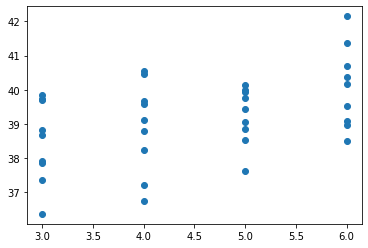

In [11]:
plt.scatter(df_scatter["r2"],df_scatter["mae"])

In [12]:
best_model=XGBRegressor(**best_params)
best_model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_delta_step=None, max_depth=4,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [13]:
file_name="dataset_protein_"+str(bar_radius)+"_"+str(ring_radius)+".xlsx"
df_pmOrig=pd.read_excel(path_inputs+file_name,sheet_name="Sheet1",index_col=0).set_index("PDB ID")#.drop(pdb_todrop,axis=0).drop(features_todrop,axis=1)
df_pmOrig["Em"]=df_pmOrig["Em"].fillna(-211)
if filter_proteins:
            df_pmOrig=df_pmOrig.loc[df_pmOrig.index.isin(proteins)]
        
df_pmOrig=df_pmOrig.reset_index().drop_duplicates().set_index("PDB ID")
df_pmOrig["pH"]=df_pmOrig["pH"].fillna(df_pmOrig["pH"].mean())
df_pm=df_pmOrig.copy()
df_pm

,Em,pH,Bar.ALA,Protein.ALA,Ring.ALA,Bar.ARG,Protein.ARG,Ring.ARG,Bar.ASN,Protein.ASN,...,_ChargeC3,_PolarityC1,_PolarityC2,_PolarityC3,_NormalizedVDWVC1,_NormalizedVDWVC2,_NormalizedVDWVC3,_HydrophobicityC1,_HydrophobicityC2,_HydrophobicityC3
PDB ID,,,,,,,,,,,,,,,,,,,,,
1AHN,-343.5,7.181203,5.0,15.00,0.00,1.0,4.00,0.0,1.00,3.00,...,0.21,0.34,0.18,0.11,0.40,0.36,0.22,0.34,0.36,0.31
1AKR,-310.5,7.000000,2.0,18.00,1.00,1.0,7.00,0.0,1.00,2.00,...,0.20,0.32,0.14,0.08,0.48,0.33,0.17,0.31,0.40,0.29
1AKT,-297.5,7.000000,1.0,17.00,0.00,1.0,7.00,0.0,2.00,3.00,...,0.20,0.32,0.15,0.08,0.47,0.33,0.17,0.32,0.40,0.29
1AKW,-320.0,7.000000,1.0,17.00,0.00,1.0,7.00,0.0,1.00,2.00,...,0.20,0.33,0.14,0.08,0.47,0.33,0.17,0.31,0.40,0.29
1AZL,-316.0,7.000000,1.0,17.00,0.00,1.0,7.00,0.0,1.00,2.00,...,0.20,0.33,0.14,0.08,0.47,0.33,0.17,0.31,0.40,0.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5OL2,-279.0,7.000000,6.0,32.00,0.00,2.0,10.67,0.0,0.33,9.33,...,0.14,0.34,0.18,0.13,0.40,0.37,0.22,0.32,0.37,0.31
5ULL,-245.5,7.000000,1.0,6.00,0.00,0.0,2.00,0.0,2.00,8.00,...,0.20,0.38,0.23,0.09,0.33,0.45,0.20,0.36,0.28,0.36
5YAK,-215.0,7.400000,1.0,12.17,0.33,5.0,13.00,1.0,3.00,9.50,...,0.11,0.38,0.21,0.19,0.29,0.41,0.29,0.32,0.33,0.34


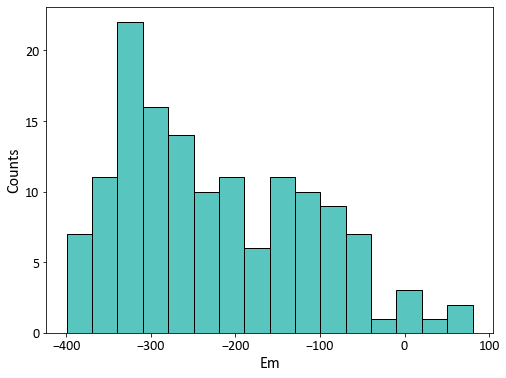

In [41]:
import seaborn as sns
#bins numero di barre
font = {'family' : 'Calibri',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.figure(figsize=(8,6))
plt.ylabel("Counts",fontsize=16)
plt.xlabel("Em",fontsize=16)
sns.histplot(data=df_pm["Em"],element="bars",color="lightseagreen",bins=15,binwidth=30)
plt.savefig("figure/barplot_em_fancy.png")

In [22]:
spearmanr(df_pm["Em"],df_pm["Bar.nNats in side chain"])

SpearmanrResult(correlation=0.5439834626111456, pvalue=3.139310119534886e-12)

In [23]:
df_pm.describe()

,Em,pH,Bar.ALA,Protein.ALA,Ring.ALA,Bar.ARG,Protein.ARG,Ring.ARG,Bar.ASN,Protein.ASN,...,_ChargeC3,_PolarityC1,_PolarityC2,_PolarityC3,_NormalizedVDWVC1,_NormalizedVDWVC2,_NormalizedVDWVC3,_HydrophobicityC1,_HydrophobicityC2,_HydrophobicityC3
count,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,...,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000
mean,-223.358865,7.181203,3.787234,24.263617,0.106028,2.180851,14.006525,0.099291,2.165461,12.336525,...,0.146383,0.344184,0.193050,0.116525,0.389007,0.368511,0.228936,0.320142,0.373617,0.307447
std,109.588340,0.636413,2.424749,14.868987,0.296265,1.782130,9.673286,0.294108,1.631287,7.723589,...,0.034315,0.022933,0.026644,0.028809,0.044454,0.038488,0.035126,0.027150,0.039248,0.025840
min,-399.500000,5.100000,0.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,...,0.090000,0.290000,0.140000,0.060000,0.290000,0.300000,0.170000,0.270000,0.280000,0.250000
25%,-314.000000,7.000000,2.000000,13.000000,0.000000,0.000000,5.000000,0.000000,1.000000,8.000000,...,0.120000,0.330000,0.180000,0.090000,0.360000,0.340000,0.200000,0.300000,0.350000,0.290000
50%,-245.500000,7.000000,3.000000,18.000000,0.000000,2.000000,13.000000,0.000000,2.000000,11.000000,...,0.140000,0.340000,0.190000,0.120000,0.380000,0.370000,0.230000,0.320000,0.380000,0.300000
75%,-132.000000,7.500000,6.000000,33.000000,0.000000,4.000000,22.000000,0.000000,3.000000,16.000000,...,0.170000,0.360000,0.220000,0.140000,0.420000,0.390000,0.250000,0.340000,0.400000,0.320000
max,73.000000,8.500000,11.000000,78.000000,1.000000,5.000000,38.000000,1.000000,8.000000,32.000000,...,0.210000,0.380000,0.240000,0.190000,0.480000,0.460000,0.320000,0.370000,0.450000,0.360000


In [24]:
X=df_pm.iloc[:,1:].values
y=df_pm.iloc[:,0].values

In [25]:
X2_df=df_pm.copy()
X2_df=X2_df.reset_index()
X2_df=X2_df.drop(["PDB ID","Em"],axis=1)
X2_df

,pH,Bar.ALA,Protein.ALA,Ring.ALA,Bar.ARG,Protein.ARG,Ring.ARG,Bar.ASN,Protein.ASN,Ring.ASN,...,_ChargeC3,_PolarityC1,_PolarityC2,_PolarityC3,_NormalizedVDWVC1,_NormalizedVDWVC2,_NormalizedVDWVC3,_HydrophobicityC1,_HydrophobicityC2,_HydrophobicityC3
0,7.181203,5.0,15.00,0.00,1.0,4.00,0.0,1.00,3.00,0.0,...,0.21,0.34,0.18,0.11,0.40,0.36,0.22,0.34,0.36,0.31
1,7.000000,2.0,18.00,1.00,1.0,7.00,0.0,1.00,2.00,0.0,...,0.20,0.32,0.14,0.08,0.48,0.33,0.17,0.31,0.40,0.29
2,7.000000,1.0,17.00,0.00,1.0,7.00,0.0,2.00,3.00,0.0,...,0.20,0.32,0.15,0.08,0.47,0.33,0.17,0.32,0.40,0.29
3,7.000000,1.0,17.00,0.00,1.0,7.00,0.0,1.00,2.00,0.0,...,0.20,0.33,0.14,0.08,0.47,0.33,0.17,0.31,0.40,0.29
4,7.000000,1.0,17.00,0.00,1.0,7.00,0.0,1.00,2.00,0.0,...,0.20,0.33,0.14,0.08,0.47,0.33,0.17,0.31,0.40,0.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,7.000000,6.0,32.00,0.00,2.0,10.67,0.0,0.33,9.33,0.0,...,0.14,0.34,0.18,0.13,0.40,0.37,0.22,0.32,0.37,0.31
137,7.000000,1.0,6.00,0.00,0.0,2.00,0.0,2.00,8.00,0.0,...,0.20,0.38,0.23,0.09,0.33,0.45,0.20,0.36,0.28,0.36
138,7.400000,1.0,12.17,0.33,5.0,13.00,1.0,3.00,9.50,0.0,...,0.11,0.38,0.21,0.19,0.29,0.41,0.29,0.32,0.33,0.34
139,7.000000,5.0,6.00,0.00,1.0,2.00,0.0,2.00,10.00,1.0,...,0.14,0.38,0.19,0.12,0.32,0.41,0.26,0.33,0.32,0.35


In [26]:
r=best_model
r.fit(X,y)
subset=X #shap.sample(X,100)
explainer=shap.KernelExplainer(r.predict,(subset))
shap_values = explainer.shap_values(subset)

Using 141 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/141 [00:00<?, ?it/s]

In [27]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X2_df.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
features_graph=feature_importance["col_name"]

In [28]:
features_graph=features_graph.replace({"Bar.ResApolari":"Bar.ApolarRes","Bar.ResAromatici":"Bar.AromaticRes", 
                                       "Protein.ResPolari":"Protein.PolarRes" })

In [29]:
[el for el in features_graph]

['Bar.nNats in side chain',
 'Protein.GLN',
 'Bar.HIS',
 'pH',
 'Protein.PRO',
 'Bar.Log(Solubility (m at 20ºC))',
 'Bar.PRO',
 'Protein.nH-bonds',
 'Around_N5.Hydrophobicity',
 '_HydrophobicityC3',
 '_PolarizabilityC3',
 'Bar.Steric hindrance / P(helix)',
 'Protein.Isoelectric point',
 'Bar.Hydrophobicity x Flex.',
 'Around_N5.Hydrophobicity x Flex.',
 'Protein.HIS',
 'Protein.log(Solub) x Hydrophobicity',
 'Ring.Vol / P(helix)',
 'Protein.ILE',
 'Bar.SER',
 'Ring.Steric hindrance / P(helix)',
 'Bar.Vol / log(solub)',
 'Bar.nH-bonds',
 'Ring.Steric hindrance',
 'Bar.Vol / P(helix)',
 'Ring.MET',
 'Ring.nOats in side chain',
 'Bar.VAL',
 'Ring.HIS',
 'Protein.TRP',
 'Ring.Hydrophobicity',
 'Ring.nNats in side chain',
 'Ring.nH-bonds',
 'Bar.P(helix) / P(sheet)',
 'Bar.ApolarRes',
 'Bar.log(Solub) x Flex',
 'Protein.RESNEG',
 'Bar.Steric hindrance',
 'Bar.GLU',
 'Bar.Isoelectric point / P(sheet)',
 'Ring.Vol / P(sheet)',
 'Ring.Isoelectric point / P(helix)',
 'Protein.log(Solub) x Flex'

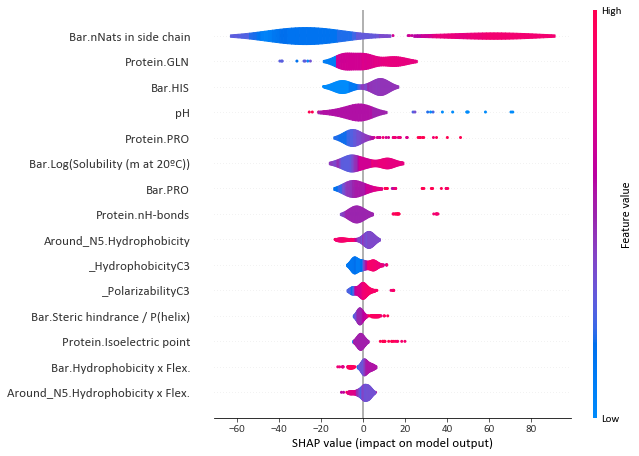

<Figure size 432x288 with 0 Axes>

In [58]:
shap.summary_plot(shap_values, subset, feature_names=features_graph, max_display=15, plot_type="violin")
plt.savefig("C:/Users/anton/OneDrive/Desktop/violinplot_luca.svg")

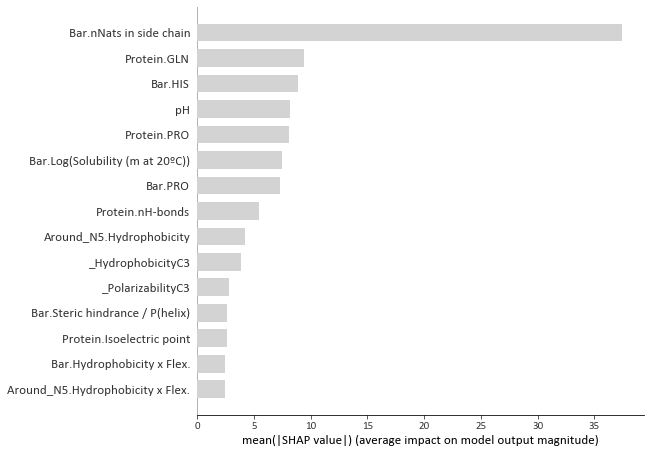

In [59]:
shap.summary_plot(shap_values, X2_df, plot_type='bar', feature_names=features_graph, max_display=15,
                  color="lightgrey",show=False)
plt.savefig("C:/Users/anton/OneDrive/Desktop/barplot_grey.svg")

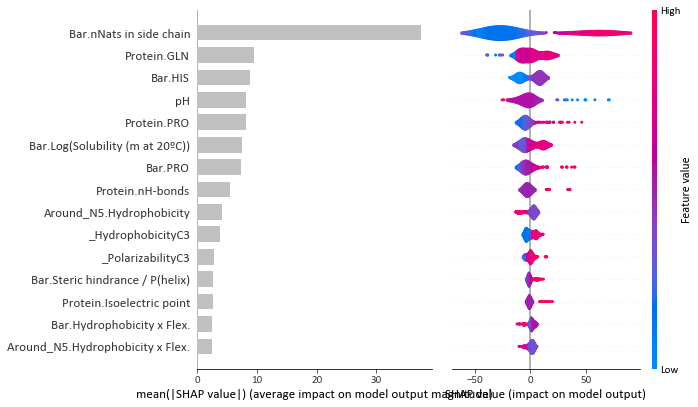

<Figure size 432x288 with 0 Axes>

In [55]:
#plt.figure(figsize=(15,6))
#plt.grid(b=None)
font = {'family' : 'Calibri',
        "weight": "normal",
        "size"   : 18}

from matplotlib import gridspec
f=plt.figure(figsize=(10,6))
plt.rc('font', **font)
#plt.axis('off')
ax0=plt.subplot(1,2,1)
shap.summary_plot(shap_values, X2_df, plot_type='bar', feature_names=features_graph, max_display=15,
                  color="silver",show=False,plot_size=None)
ax1=plt.subplot(1,2,2)
shap.summary_plot(shap_values, subset ,feature_names=features_graph,max_display=15,plot_type="violin",show=False,plot_size=None)
ax1.get_yaxis().set_visible(False)
#ax0.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()
plt.savefig("C:/Users/anton/OneDrive/Desktop/violinplot_barplot_horiz.png",dpi=400)

In [32]:
#plt.grid(b=None)


In [34]:
shap.initjs()
shap.force_plot(
                explainer.expected_value,
                shap_values,
                subset,
                feature_names=features_graph
               )